In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import TimeSeries
import pandas as pd
import os

In [ ]:
# Data
period = np.array([9.8082, 9.8039, 9.7990, 9.8009, 9.7890, 9.7722])
mjd = [60044, 60047, 60112, 60130, 60174, 60203]
p_err = np.array([0.01753, 0.00059, 0.00056, 0.00059, 0.00055, 0.00070])

# Frequency and error in mHz
frequency_mHz = (10**3 / period)
f_err_mHz = (p_err / period**2) * 10**3  # mHz units

# Plot with error bars
plt.figure(figsize=(6,4))
plt.errorbar(mjd, frequency_mHz, fmt="-o", capsize=2, markersize=4, label="Frequency")

# Annotate each point with the frequency value
for i in range(len(mjd)):
    plt.annotate(f'{frequency_mHz[i]:.4f}', (mjd[i], frequency_mHz[i]), 
                 textcoords="offset points", xytext=(0,5), ha='center')

# Add vertical lines
plt.axvline(60120, ls="--", color="grey")
plt.axvline(60190, ls="--", color="grey")

# Labels and title
plt.ylabel('Frequency (mHz)')
plt.xlabel('MJD')
plt.title("Frequency (mHz) vs MJD for NICER (0.8-12 keV)")
plt.grid()
plt.legend()

# Show the plot
plt.show()


In [4]:
#### Testing the fits file header ####
# # profile = fits.open('./6050390201/xti/event_cl/6050390201_pulse_profile.fits')
# profile=fits.open('./6050390201/xti/event_cl/ni6050390201_cl_night_barycorrmpu7_sr_night.lc')
# data = profile[1].data
# profile[1].header
# # intensities = data['RATE1']
# # phase= data['PHASE']

## Using efold output file (already folded light curve with fixed phase bin numbers)

In [3]:
def read_files(path):
    # Open the FITS file
    profile = fits.open(path)
    data = profile[1].data
    intensities = data['RATE1']
    phase = data['PHASE']
    errors = data['ERROR1']

    # Find the maximum and minimum intensities
    I_max = np.max(intensities)
    I_min = np.min(intensities)

    # Calculate the pulsed fraction
    pulsed_fraction = (I_max - I_min) / (I_max + I_min)
    
    # Calculate the phase-averaged count rate
    r_bar = np.mean(intensities)
    # Calculate the RMS pulsed fraction (pf_rms)
    rms_pulsed_fraction = np.sqrt(np.mean((intensities - r_bar) ** 2)) / r_bar
    
    return phase, intensities, errors, pulsed_fraction,rms_pulsed_fraction


def calc_pf_plot(lc_arr,plot=True):
    pf_arr=np.array([])
    rmspf_arr=np.array([])
    for lc in lc_arr: 
        phase_arr, intensity_arr,error_arr, pf,rmspf = read_files(lc)
        pf_arr=np.append(pf_arr,pf)
        rmspf_arr=np.append(rmspf_arr,rmspf)
        # Print the results
        print(f"File: {lc}")
        print(f"Max photon flux: {intensity_arr.max():.4f} counts/sec")
        print(f"Pulsed Fraction: {pf:.4f}, RMS Pulsed Fraction: {rmspf:.4f}")
        
        # Repeat the phase, intensity, and error to plot twice for visual appearance (phase 0 to 2)
        phase_arr_double = np.concatenate([phase_arr, phase_arr + 1])
        intensity_arr_double = np.concatenate([intensity_arr, intensity_arr])
        error_arr_double = np.concatenate([error_arr, error_arr])
        if(plot==True):
            plt.figure(figsize=(8,4))
            plt.errorbar(phase_arr_double, intensity_arr_double, yerr=error_arr_double, fmt='-o', capsize=2, label='Light Curve',alpha=0.7)
            plt.xlabel("Phase (0-2)")
            plt.ylabel("Flux (counts/sec)")
            plt.title(f"Folded Light Curve (2 Cycles)\nPulsed Fraction: {rmspf:.4f}")
            plt.grid(True)
            plt.legend()
            plt.show()
    return pf_arr,rmspf_arr

In [ ]:
## Using the efold method
lc1='./6050390201/xti/event_cl/6050390201_pulse_profile.fits'
lc2='./6050390204/xti/event_cl/6050390204_pulse_profile.fits'
lc3='./6050390227/xti/event_cl/6050390227_pulse_profile.fits'
lc4='./6050390244/xti/event_cl/6050390244_pulse_profile.fits'
lc5='./6050390261/xti/event_cl/6050390261_pulse_profile.fits'
lc6='./6050390284/xti/event_cl/6050390284_pulse_profile.fits'
lc_arr=[lc1,lc2,lc3,lc4,lc5,lc6]

pf_arr,rmspf_arr=calc_pf_plot(lc_arr,plot=True)

### Plotting simple PF and rms PF vs count rate of Swift (per cm^2)

In [ ]:
count_rate_swift=np.array([0.0089357,0.00922004,0.19404365,0.2593448,0.09031704,0.01413414])
plt.figure(figsize=(8,4))
#plt.plot(pf_arr,count_rate_swift,"-o")
plt.plot(rmspf_arr,count_rate_swift,"-o",label='RMS PF formula')
plt.ylabel('count rate (count/s-$cm^2$)')
plt.xlabel('pulsed fraction')
plt.title('pulsed fraction against count rate of SWIFT BAT from using efold output light curve')
plt.legend()
plt.grid()

## Using nicerl3-lc output light curve directly. Rms PF

The count rate seems to be little different (possibly due to how I bin vs how efold bins)

The peak seems to have a time offset. (Even with using timezero as reference it is not folding correctly)

In [8]:
# # Function to read FITS file, fold the light curve, and calculate RMS pulsed fractions
# def read_files_rms(path, period, num_bins, use_timezero):
#     # Open the FITS file
#     with fits.open(path) as profile:
#         data = profile[1].data
#         header = profile[1].header

#         # Extract the TIMEZERO from the header if use_timezero is True, taking this as epoch ref?
#         time_zero = header.get('TIMEZERO', 0.0) if use_timezero else 0.0

#     # Extract the time, intensity (rate), and error values
#     time = data['TIME']  
#     intensities = data['RATE'] 
#     errors = data['ERROR']

#     # Adjust time using TIMEZERO if applicable
#     time_adjusted = time - time_zero

#     # Fold the light curve using the provided period
#     phases = (time_adjusted % period) / period  # Normalize phase between 0 and 1

#     # Bin the data into the requested number of phase bins
#     bin_edges = np.linspace(0, 1, num_bins + 1)
#     phase_bins = (bin_edges[:-1] + bin_edges[1:]) / 2  # Midpoints of bins
#     intensity_binned, _ = np.histogram(phases, bins=bin_edges, weights=intensities)
#     error_binned, _ = np.histogram(phases, bins=bin_edges, weights=errors**2)
#     counts, _ = np.histogram(phases, bins=bin_edges)

#     # Compute average intensity and error in each bin
#     intensity_binned /= counts
#     error_binned = np.sqrt(error_binned) / counts

#     # Calculate the phase-averaged count rate
#     r_bar = np.mean(intensity_binned)

#     # Calculate the RMS pulsed fraction (f_rms)
#     rms_pulsed_fraction = np.sqrt(np.mean((intensity_binned - r_bar) ** 2)) / r_bar
    
#     return phase_bins, intensity_binned, error_binned, rms_pulsed_fraction

# def calc_pfrms_plot(lc_arr, period_arr, phase_bins_arr, use_timezero=True,plot=True):
#     pf_arr = np.array([])

#     # Ensure the input arrays have the same length
#     assert len(lc_arr) == len(period_arr) == len(phase_bins_arr), "The number of light curves, periods, and phase bins must match."

#     for lc, period, phase_bins in zip(lc_arr, period_arr, phase_bins_arr):
#         # Read the phase, intensities, and pulsed fraction
#         phase_arr, intensity_arr, error_arr, pf = read_files_rms(lc, period, phase_bins, use_timezero)
#         pf_arr = np.append(pf_arr, pf)

#         # Print the results
#         print(f"File: {lc}")
#         print(f"Period: {period:.4f} sec")
#         print(f"Phase bins: {phase_bins}")
#         print(f"Max photon flux: {intensity_arr.max():.4f} counts/sec")
#         print(f"Pulsed Fraction: {pf:.4f}")

#         # Repeat the phase, intensity, and error to plot over two cycles (0 to 2)
#         phase_arr_double = np.concatenate([phase_arr, phase_arr + 1])
#         intensity_arr_double = np.concatenate([intensity_arr, intensity_arr])
#         error_arr_double = np.concatenate([error_arr, error_arr])
        
#         if(plot==True):
#             # Plot the folded light curve with error bars
#             plt.figure(figsize=(8, 4))
#             plt.errorbar(phase_arr_double, intensity_arr_double, yerr=error_arr_double, fmt='-o', capsize=2, label=f'Light Curve (Period: {period:.4f} s)', alpha=0.7)
#             plt.xlabel("Phase (0-2)")
#             plt.ylabel("Flux (counts/sec)")
#             plt.title(f"Folded Light Curve (2 Cycles)\nPulsed Fraction: {pf:.4f}")
#             plt.grid(True)
#             plt.legend()

#             # Show the plot
#             plt.show()

#     return pf_arr

# lc1 = './6050390201/xti/event_cl/ni6050390201_cl_night_barycorrmpu7_sr_night.lc'
# lc2 = './6050390204/xti/event_cl/ni6050390204_cl_night_barycorrmpu7_sr_night.lc'
# lc3 = './6050390227/xti/event_cl/ni6050390227_cl_night_barycorrmpu7_sr_night.lc'
# lc4 = './6050390244/xti/event_cl/ni6050390244_cl_night_barycorrmpu7_sr_night.lc'
# lc5 = './6050390261/xti/event_cl/ni6050390261_cl_night_barycorrmpu7_sr_night.lc'
# lc6 = './6050390284/xti/event_cl/ni6050390284_cl_night_barycorrmpu7_sr_night.lc'

# lc_arr = [lc1, lc2, lc3, lc4, lc5, lc6]
# period = np.array([9.8082, 9.8039, 9.7990, 9.8009, 9.7890, 9.7722])
# phase_bins=[64,64,64,64,64,64]

# # Example of calculating pulsed fraction for all light curves
# pf_arr = calc_pfrms_plot(lc_arr, period,phase_bins,plot=True )

In [9]:
# count_rate_swift=np.array([0.0089357,0.00922004,0.19404365,0.2593448,0.09031704,0.01413414])
# plt.figure(figsize=(8,4))
# plt.plot(rmspf_arr,count_rate_swift,"-o",label='RMS from efold output',c='b')
# plt.plot(pf_arr,count_rate_swift,"-o",label='RMS from python folding',c='g')
# plt.ylabel('count rate (count/s-$cm^2$)')
# plt.xlabel('pulsed fraction')
# plt.title('pulsed fraction against count rate of SWIFT BAT from using efold output light curve')
# plt.legend()
# plt.grid()

## Folding by python

In [2]:
def read_fits_lightcurve(fits_file):
    with fits.open(fits_file) as hdulist:
        rate_data = hdulist['RATE'].data
        time = rate_data['TIME']
        rate = rate_data['RATE']
        rate_error = rate_data['ERROR']  # or the correct column name for the error
        tstart = hdulist[1].header['TSTART']

    return tstart, time, rate, rate_error

In [3]:
def bin_time_series(time, rate, rate_error, bin_size):
    num_bins = int((time.max() - time.min()) // bin_size)
    # Bin the data using np.histogram
    binned_time = np.linspace(time.min(), time.max(), num_bins)
    binned_rate = np.zeros(num_bins)
    binned_rate_error = np.zeros(num_bins)

    for i in range(num_bins - 1):
        # Find the indices within the current bin
        bin_indices = np.where((time >= binned_time[i]) & (time < binned_time[i+1]))[0]
        if len(bin_indices) > 0:
            binned_rate[i] = np.mean(rate[bin_indices])
            binned_rate_error[i] = np.sqrt(np.sum(rate_error[bin_indices]**2)) / len(bin_indices)

    return binned_time[:-1], binned_rate[:-1], binned_rate_error[:-1]


def fold_light_curve(time, rate, rate_error, period, num_phase_bins, tstart):
    # Calculate the relative time with respect to 0 value of time array. It starts from 2.1 sec for some reason
    relative_time = time
    phase = (relative_time % period) / period
    phase_bin_size = period / num_phase_bins
    phase_bins = np.linspace(0, 1, num_phase_bins + 1)
    binned_rate = np.zeros(num_phase_bins)
    binned_rate_error = np.zeros(num_phase_bins)

    for i in range(num_phase_bins):
        bin_indices = np.where((phase >= phase_bins[i]) & (phase < phase_bins[i+1]))[0]
        if len(bin_indices) > 0:
            binned_rate[i] = np.mean(rate[bin_indices])
            binned_rate_error[i] = np.sqrt(np.sum(rate_error[bin_indices]**2)) / len(bin_indices)

    return phase_bins[:-1], binned_rate, binned_rate_error

In [4]:
# Function to calculate phase-resolved RMS
def calculate_rms(phase, binned_rate):
    I_max = np.max(binned_rate)
    I_min = np.min(binned_rate)

    # Calculate the pulsed fraction
    pulsed_fraction = (I_max - I_min) / (I_max + I_min)
    
    # Calculate the phase-averaged count rate
    r_bar = np.mean(binned_rate)
    
    # Calculate the RMS pulsed fraction (pf_rms)
    rms_pulsed_fraction = np.sqrt(np.mean((binned_rate - r_bar) ** 2)) / r_bar
    
    return pulsed_fraction, rms_pulsed_fraction


def plot_folded_light_curve(phase, binned_rate, binned_rate_error, obs_id, output_folder):
    # Repeat the phase and binned data to cover two cycles (0-2)
    extended_phase = np.concatenate([phase, phase + 1])
    extended_binned_rate = np.concatenate([binned_rate, binned_rate])
    extended_binned_rate_error = np.concatenate([binned_rate_error, binned_rate_error])

    # Plot the folded light curve for two cycles
    plt.figure(figsize=(12,5))
    plt.errorbar(extended_phase, extended_binned_rate, yerr=extended_binned_rate_error, fmt='-o', markersize=3, label='Folded Light Curve')
    plt.xlabel('Phase (0-2)')
    plt.ylabel('Count Rate')
    plt.title(f'Folded Light Curve for ObsID {obs_id} (Two Cycles)')
    plt.grid(True)
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Save the plot to the folder
    plot_file = os.path.join(output_folder, f'{obs_id}_folded_curve.png')
    plt.savefig(plot_file)
    plt.show()
    plt.close()

In [ ]:
# Load the text file data using pandas
input_file = 'all_lc_periods_chisq.txt'
df = pd.read_csv(input_file, delimiter='\t')

# Filter out rows where period is "-none-"
df = df[df['Period'] != "-none-"]

# Convert the 'Period' column to float for valid entries
df['Period'] = df['Period'].astype(float)
df['LC_File_Path'] = df['LC_File_Path'].astype(str)

# File to save RMS and pulsed RMS values
rms_output_file = 'rms_pulsed_rms.txt'

# Open the output file in write mode and add headers
with open(rms_output_file, 'w') as f:
    f.write('ObsID\tRMS_PF\tPF\n')

# Loop through each row and process the light curve
phase_bins = 64  # Set your desired number of phase bins
time_bin_size = 0.01  # Adjust as needed

for index, row in df.iterrows():
    obs_id = row['LC_File_Path']
    period = row['Period']
    
    # Construct the path to the light curve file
    lc_file = f'./reduced_output/{obs_id}/ni{obs_id}_cl_night_barycorrmpu7_sr_night.lc'

    # Check if the file exists before proceeding
    if os.path.exists(lc_file):
        try:
            # Read the light curve data
            tstart, time, rate, rate_error = read_fits_lightcurve(lc_file)

            # Perform the folding operation
            phase, binned_rate, binned_rate_error = fold_light_curve(time, rate, rate_error, period, phase_bins, tstart)

            # Calculate the phase-resolved RMS
            pulsed_fraction, rms_pulsed_fraction = calculate_rms(phase, binned_rate)

            # Append the RMS values to the output text file
            with open(rms_output_file, 'a') as f:
                f.write(f'{obs_id}\t{rms_pulsed_fraction:.6f}\t{pulsed_fraction:.6f}\n')

            # Define output folder for folded light curves
            output_folder = f'./folded_curves/{obs_id}'

            # Plot and save the folded light curve for two cycles
            plot_folded_light_curve(phase, binned_rate, binned_rate_error, obs_id, output_folder)

            print(f'Processed ObsID {obs_id} with period {period}. RMS and pulsed RMS saved.')

        except Exception as e:
            # Catch any exceptions that might occur and print the error
            print(f"Error processing {lc_file}: {e}")
    else:
        # If the file doesn't exist, print a warning and skip the entry
        print(f"File not found: {lc_file}, skipping ObsID {obs_id}")

In [15]:
##Finding out zero time for the same. 
# hdul=fits.open(lc1)
# print(hdul[1].header['TSTART']-hdul[1].header['TIMEZERO'])
# hdul[1].header['TSTART'],hdul[1].header['TIMEZERO']

## Same reference epoch attempt

In [ ]:
## read the PF record for plotting
pf_data=pd.read_csv('rms_pulsed_rms.txt',sep='\t',header=0)
pf_data=pf_data.sort_values(by='ObsID')

In [ ]:
plt.plot(pf_data['RMS_PF'],'-->')
plt.title('Pulsed Fraction')

[ 780.00073 1040.001   1040.001   ... 1902.4409  1395.1233  2029.2703 ]
[2.98462951e+08 2.98462951e+08 2.98462951e+08 ... 2.98496641e+08
 2.98496641e+08 2.98496641e+08]
20112
[0.09963791 0.10065793 0.10167795 ... 0.61414828 0.61516833 0.6161884 ]


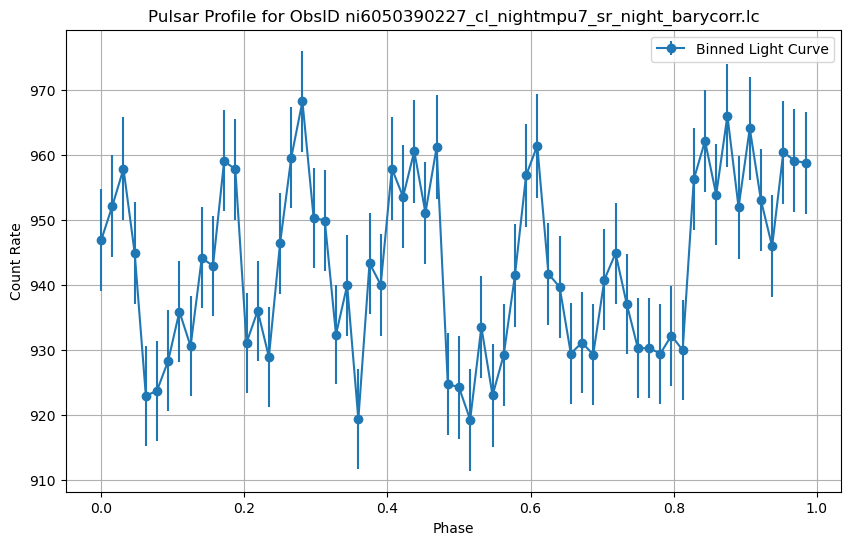

Processed file: ./reduced_output/6050390227/ni6050390227_cl_nightmpu7_sr_night_barycorr.lc
[ 887.8057  1014.63513  380.48816 ...  507.31757  760.9763  1141.4645 ]
[2.98574361e+08 2.98574361e+08 2.98574361e+08 ... 2.98596985e+08
 2.98596985e+08 2.98596985e+08]
20112
[0.36134134 0.36236151 0.36338167 ... 0.75107813 0.75209833 0.75311853]


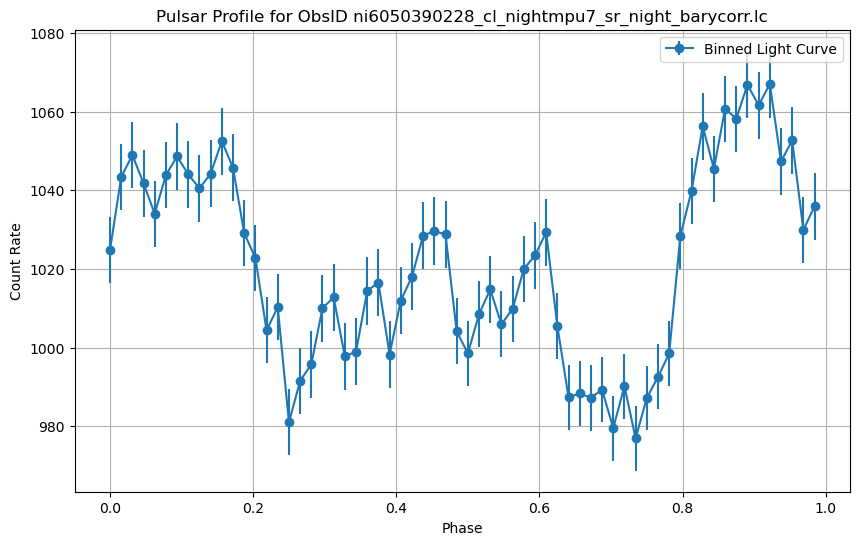

Processed file: ./reduced_output/6050390228/ni6050390228_cl_nightmpu7_sr_night_barycorr.lc


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import os

# Reference epoch
fixed_epoch = 20112  # Given reference epoch in MJD

def read_fits_lightcurve(fits_file):
    with fits.open(fits_file) as hdulist:
        rate_data = hdulist['RATE'].data
        time = rate_data['TIME']
        rate = rate_data['RATE']
        rate_error = rate_data['ERROR']  # Adjust if the correct column name is different
        tstart = hdulist[1].header['TSTART']  # Read TSTART from the header
        print(rate)
    return tstart, time, rate, rate_error

def fold_light_curve_fixed_epoch(time, rate, rate_error, period, tstart, num_phase_bins):
    # Adjust the time array based on TSTART
    adjusted_time = time - fixed_epoch  # Adjust time by TSTART
    print(time)
    print(fixed_epoch)
    phase = (adjusted_time/ period) % 1  # Calculate phase
    print(phase)
    # Create phase bins
    phase_bins = np.linspace(0, 1, num_phase_bins + 1)
    binned_rate = np.zeros(num_phase_bins)
    binned_rate_error = np.zeros(num_phase_bins)

    for i in range(num_phase_bins):
        # Find indices of data points within the current phase bin
        bin_indices = np.where((phase >= phase_bins[i]) & (phase < phase_bins[i + 1]))[0]
        if len(bin_indices) > 0:
            binned_rate[i] = np.mean(rate[bin_indices])
            binned_rate_error[i] = np.sqrt(np.sum(rate_error[bin_indices] ** 2)) / len(bin_indices)

    return phase_bins[:-1], binned_rate, binned_rate_error

def plot_light_curve_fixed_epoch(phase, binned_rate, binned_rate_error, obs_id):
    plt.figure(figsize=(10, 6))
    plt.errorbar(phase, binned_rate, yerr=binned_rate_error, fmt='-o', label='Binned Light Curve')
    plt.xlabel('Phase')
    plt.ylabel('Count Rate')
    plt.title(f'Pulsar Profile for ObsID {obs_id}')
    plt.grid()
    plt.legend()
    
    # Save the plot
    # output_dir = './folded_curves/obsid'
    # os.makedirs(output_dir, exist_ok=True)
    # plt.savefig(os.path.join(output_dir, f'pulse_profile_{obs_id}.png'))
    plt.show()
    plt.close()

# Define the light curve files and periods
lc_files = [
    './reduced_output/6050390227/ni6050390227_cl_nightmpu7_sr_night_barycorr.lc',
    './reduced_output/6050390228/ni6050390228_cl_nightmpu7_sr_night_barycorr.lc'
]
periods = [9.8008, 9.8007]  # Corresponding periods for the light curves
num_phase_bins = 64  # Number of phase bins

# Process the light curves
for lc_file, period in zip(lc_files, periods):
    try:
        # Read the light curve data
        tstart, time, rate, rate_error = read_fits_lightcurve(lc_file)

        # Perform the folding operation with the fixed epoch
        phase, binned_rate, binned_rate_error = fold_light_curve_fixed_epoch(time, rate, rate_error, period, tstart, num_phase_bins)

        # Save the plot
        plot_light_curve_fixed_epoch(phase, binned_rate, binned_rate_error, lc_file.split('/')[-1])

        print(f'Processed file: {lc_file}')
    except FileNotFoundError:
        print(f'File not found: {lc_file}')
    except Exception as e:
        print(f'Error processing file {lc_file}: {e}')
